# Store Sales - Time Series Forecasting
https://www.kaggle.com/competitions/store-sales-time-series-forecasting

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
$\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}$
where:

𝑛 is the total number of instances,<br>
𝑦̂ 𝑖 is the predicted value of the target for instance (i),<br>
𝑦𝑖 is the actual value of the target for instance (i), and,<br>
log is the natural logarithm.

The training data; <br>
***store_nbr*** identifies the store at which the products are sold.<br>
***family*** identifies the type of product sold.<br>
***sales*** gives the total sales for a product family at a particular store at a given date.
Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).<br>
***onpromotion*** gives the total number of items in a product family that were being promoted at a store at a given date.

### Preprocessing

In [1]:
# Setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime
import math

In [2]:
# Setup the training data set
dataset = pd.read_csv('train.csv', parse_dates=["date"])
print(dataset.shape)
dataset.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [3]:
# Grouping by Dates
df = dataset.groupby(by="date").sum()

# Including 'date_parsed' as a column
df.reset_index(inplace=True)
df = df.drop(labels=['id', 'store_nbr'], axis=1)
df['time'] = df.index

In [4]:
print(df.shape)
df.head()

(1684, 4)


,date,sales,onpromotion,time
0,2013-01-01,2511.618999,0,0
1,2013-01-02,496092.417944,0,1
2,2013-01-03,361461.231124,0,2
3,2013-01-04,354459.677093,0,3
4,2013-01-05,477350.121229,0,4


In [5]:
# # Using sklearn 'train_test_split'

# from sklearn.model_selection import train_test_split

# X = df[['time', 'date', 'onpromotion' ]]
# y = df[['sales' ]]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=None)

In [9]:
# Spliting 80:20
train = df.sample(frac=0.8,random_state=None)
test = df.drop(train.index)

In [10]:
# Separating features(X) and target(y)
X_train = train[['time', 'date', 'onpromotion' ]]
X_test = test[['time', 'date', 'onpromotion' ]]
y_train = train['sales']
y_test = test['sales']

In [11]:
X_train.head()

,time,date,onpromotion
1402,1402,2016-11-06,14731
581,581,2014-08-06,515
377,377,2014-01-14,0
944,944,2015-08-05,8919
140,140,2013-05-21,0


## Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

# Train the model
lin_model = LinearRegression()
lin_model.fit(X_train.loc[:, ['time']], y_train)

# Store the fitted values as a time series with the same time index as
# the training data
lin_y_pred = pd.Series(lin_model.predict(X_test.loc[:, ['time']]), index=X_test.index)

Text(0.5, 1.0, 'Linear Regression on Test set')

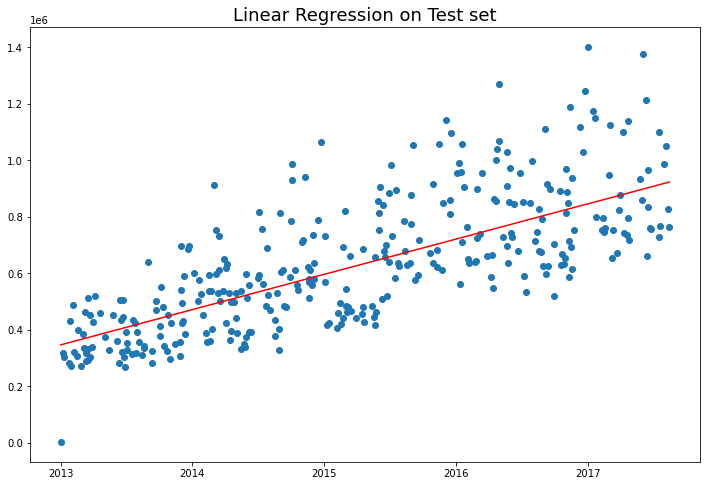

In [13]:
lin_fig = plt.figure(figsize=(12, 8))
plt.scatter(X_test['date'], y_test)
plt.plot(X_test['date'], lin_y_pred, '-', color='r')
plt.title("Linear Regression on Test set", fontsize=18)

In [25]:
# Error Function
def error(y_pred):
    pred_log = np.array([math.log(i+1) for i in y_pred])
    act_log = np.array([math.log(i+1) for i in y_test])
    dum_error = sum((pred_log - act_log)**2)/len(pred_log)
    linear_error = np.power(dum_error, 1/2)
    return round(linear_error, 4)

In [26]:
# Computing Error from Linear Regression
print("Error from Linear Regression is", error(lin_y_pred))

Error from Linear Regression is 0.3565


## Trend

In [16]:
# Recall
df.head()

,date,sales,onpromotion,time
0,2013-01-01,2511.618999,0,0
1,2013-01-02,496092.417944,0,1
2,2013-01-03,361461.231124,0,2
3,2013-01-04,354459.677093,0,3
4,2013-01-05,477350.121229,0,4


In [17]:
trendSeries = df[['date', 'sales']].set_index("date").to_period("D")
trendSeries.head()

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


In [18]:
# average with appropriate parameters for trend estimation.
moving_trend = trendSeries.rolling(
    window=365,       # 365-days window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean() 

<AxesSubplot:title={'center':'Store Sales 30-Day Moving Average'}, xlabel='date'>

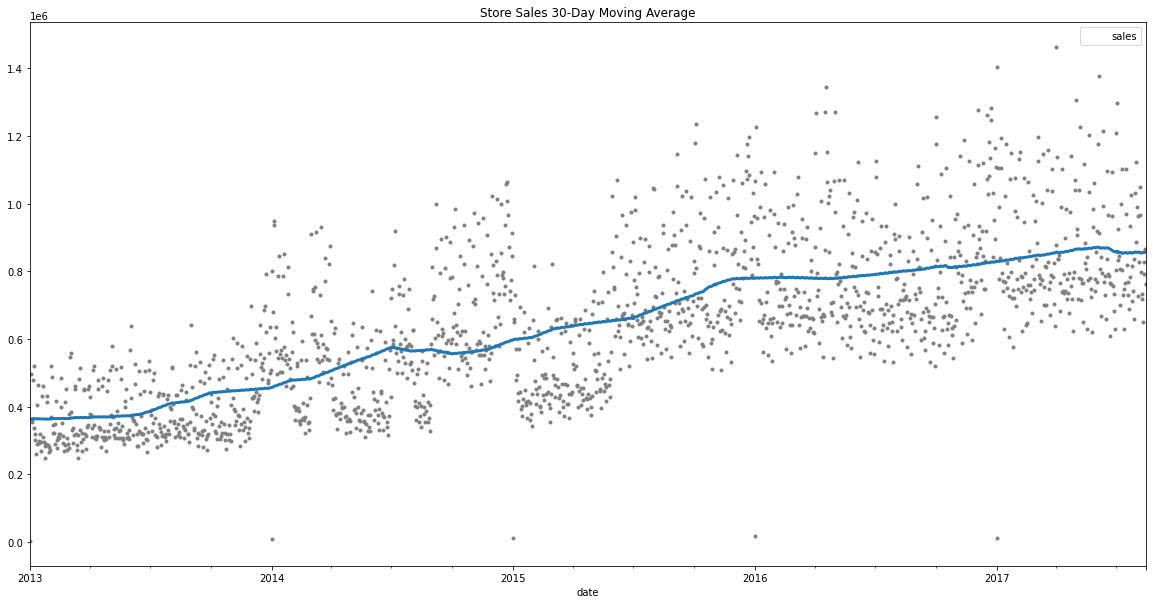

In [19]:
trend_ax1 = trendSeries.plot(figsize=(20, 10), style=".", color="0.5")
moving_trend.plot(
    ax=trend_ax1, linewidth=3, title="Store Sales 30-Day Moving Average", legend=False,
)

In [20]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=trendSeries.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X_trend = dp.in_sample()

X_trend.head()

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


In [21]:
y_trend = trendSeries["sales"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
trend_model = LinearRegression(fit_intercept=False)
trend_model.fit(X_trend, y_trend)

trend_y_pred = pd.Series(trend_model.predict(X_trend), index=X_trend.index)

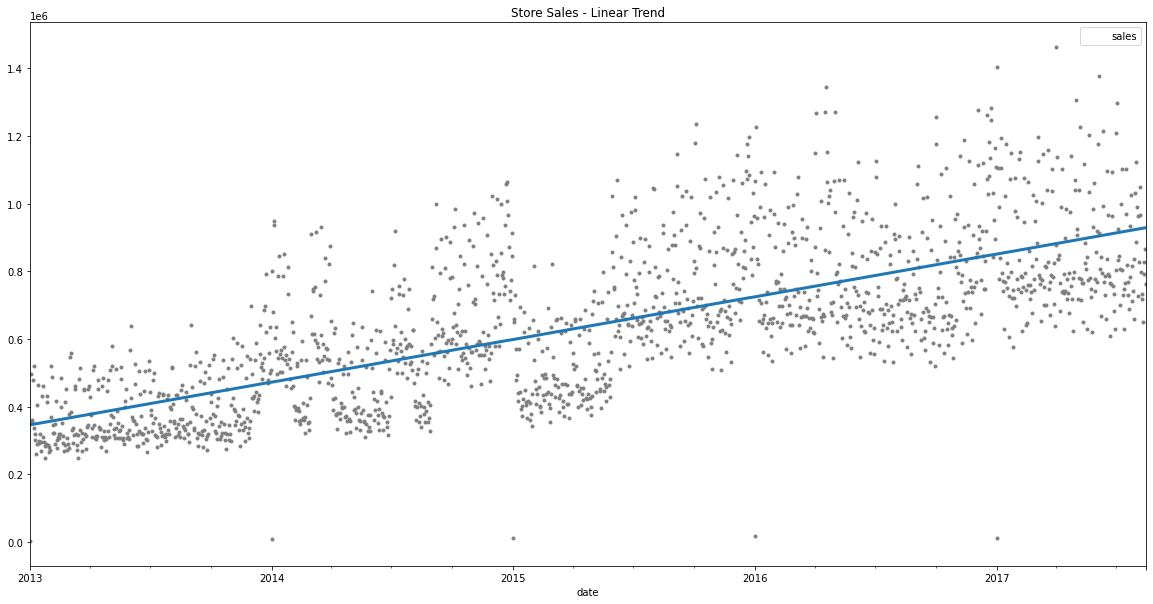

In [22]:
trend_ax2 = trendSeries.plot(figsize=(20,10), style=".", color="0.5", title="Store Sales - Linear Trend")
_ = trend_y_pred.plot(ax=trend_ax2, linewidth=3, label="Trend")

In [23]:
# Out of Sample for next 180 days
trend_X_oos = dp.out_of_sample(steps=180)
trend_y_fore = pd.Series(trend_model.predict(trend_X_oos), index=trend_X_oos.index)
trend_y_fore.head()

2017-08-16    929336.264012
2017-08-17    929682.590278
2017-08-18    930028.916544
2017-08-19    930375.242810
2017-08-20    930721.569076
Freq: D, dtype: float64

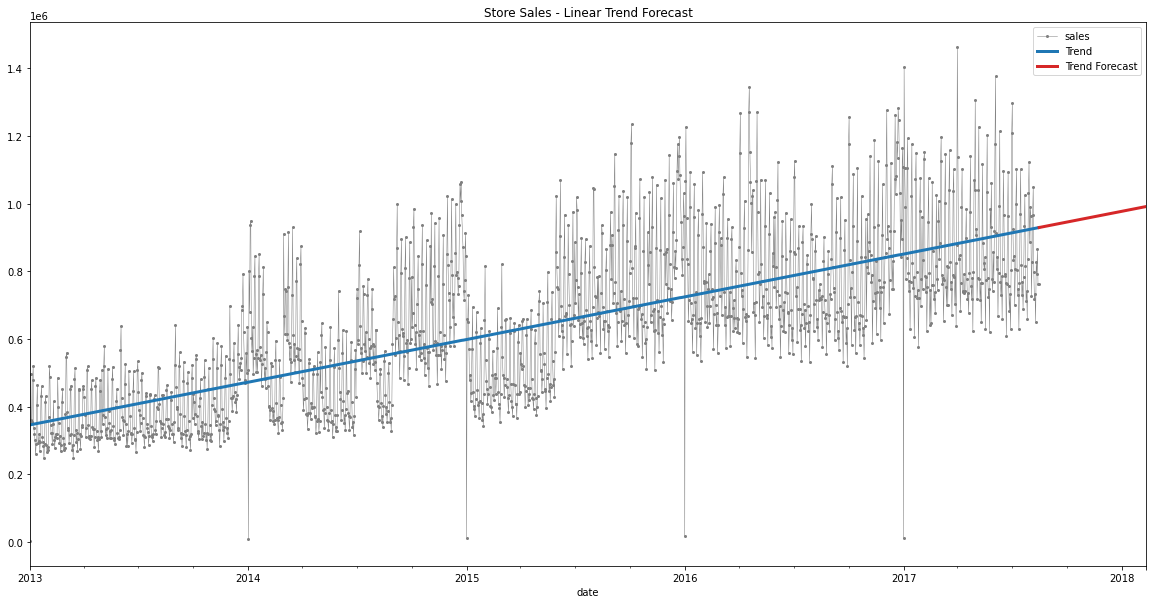

In [24]:
# trend forecast for the next 180 days
trend_ax3 = trendSeries["2013-01":].plot(figsize=(20,10), linewidth=0.5, marker="o", markersize=2, color="0.5", title="Store Sales - Linear Trend Forecast")
trend_ax3 = trend_y_pred["2013-01":].plot(ax=trend_ax3, linewidth=3, label="Trend")
trend_ax3 = trend_y_fore.plot(ax=trend_ax3, linewidth=3, label="Trend Forecast", color="C3")
_ = trend_ax3.legend()

## Seasonality